 ----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
<h1><center>
    
Practical exam on Computer Vision: Part II
    
(January, 18th, 2024)
</center></h1>   

Consider the following:

- You can answer in English, Spanish or Catalan. 

- Add title to figures and add sufficient comments on the code to understand it.

- Make sure to print and plot exactly what it is indicated. If a reference image is provided, your output is expected to be exactly the same unless instructed differently. 

- At the end of the exam, upload only your .ipynb file (no need to upload the images)
    
- Make sure your code can be ran by us without errors.

- Use packages and solutions that were covered in your class and tutorials. If you are unsure about using a particular package, you should seek clarification from your instructor to confirm whether it is allowed.

- Please note that partial credit will be given based on the correctness of the code and the logic demonstrated. If certain parts of your code or answers are accurate, even if the final output is not entirely correct, you may still receive points.

----------------------------------------------------------------------------------------------------

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import io, img_as_ubyte, img_as_float, exposure
from skimage.io import imsave, imread
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.feature import hog
import matplotlib.patches as patches
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from skimage.transform import integral_image
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA

## Exercise 1

### Improving the HOG detection

A collaboration has been initiated between several departments at the University of Barcelona and a big company. As part of the collaboration, an exercise has been assigned to assess potential new team members. This exercise is a modified version of one covered in class. 

In the earlier task, we examined the effectiveness of the HOG descriptor in person detection by employing a uniform template across various images. Now, we aim to deepen its understanding by comparing the impact of using different templates.

**Ex.1.1** (1 points) Load the images `silhouette_cropped.png`, `person_template1.bmp` and `person_template2.png` from the folder `images`. Obtain their HOG descriptors and visualize them. Use the default parameters of the HOG function. All the images should be transformed to grayscale. Take as an example the following image:

<img src="images/exercise11_1.png" width="315" height="350"><img src="images/exercise11_2.png" width="315" height="350"><img src="images/exercise11_3.png" width="315" height="350">

In [2]:
# Auxiliary function to display a set of images with titles
def showImage(figsize, images, titles, cmap='gray', show_axis=False):
    if len(images) != len(titles):
        raise ValueError("The number of images and titles must be the same.")
    
    # Calculate the number of rows needed for 3 images per row
    n_rows = int(np.ceil(len(images) / 3))
    fig = plt.figure(figsize=figsize)

    for index, image in enumerate(images):
        # Calculate the appropriate row and column for each image
        row = index // 3 + 1
        col = index % 3 + 1
        ax = fig.add_subplot(n_rows, 3, index + 1)
        ax.set_title(titles[index])
        ax.imshow(image, cmap=cmap)
        if not show_axis:
            ax.axis('off')
    plt.show()

In [3]:
# Function to convert any image to grayscale, handling alpha channel if present
def to_grayscale(image):
    # Check if the image has 3 dimensions (row, column, channel)
    if len(image.shape) == 3:
        # Check if the image has 4 channels (RGBA)
        if image.shape[-1] == 4:
            # Convert RGBA to RGB
            image = image[..., :3] # Remove the alpha channel
        # Now convert to grayscale
        return rgb2gray(image)
    # If the image is already 2D, return as is
    return image

In [4]:
# Auxiliary function to get the HOG features of an image using the default parameters
def getHOG(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), channel_axis=None):
    img_gray_f = img_as_float(image)

    if channel_axis is not None:
        fd, hog_image = hog(img_gray_f, orientations=orientations, pixels_per_cell=pixels_per_cell,
                        cells_per_block=cells_per_block, visualize=True, channel_axis=channel_axis)
    else:
        fd, hog_image = hog(img_gray_f, orientations=orientations, pixels_per_cell=pixels_per_cell,
                        cells_per_block=cells_per_block, visualize=True)
    return hog_image

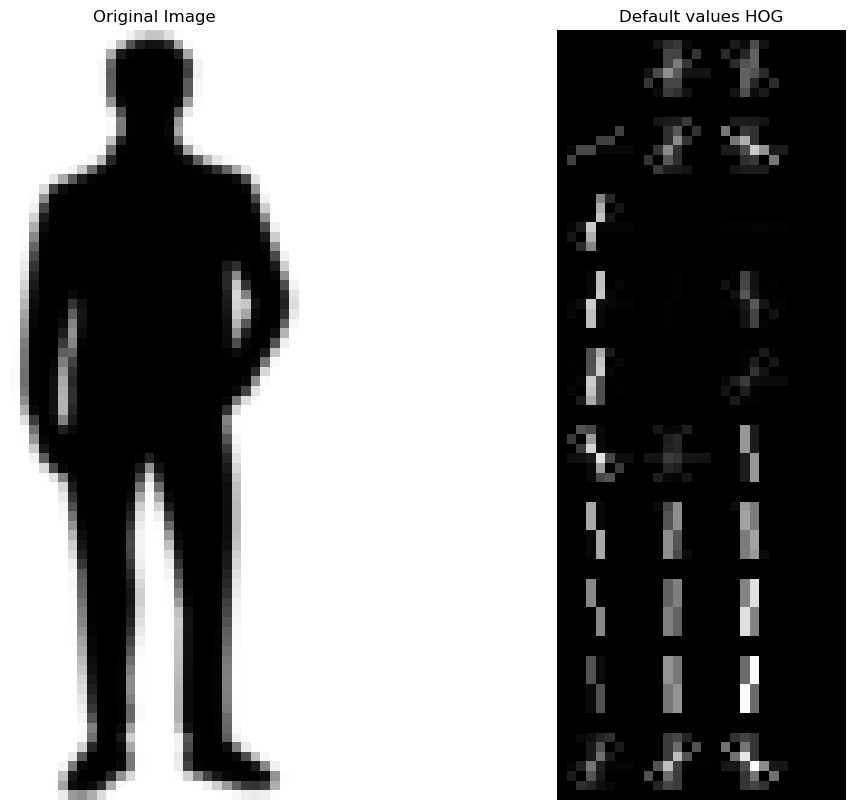

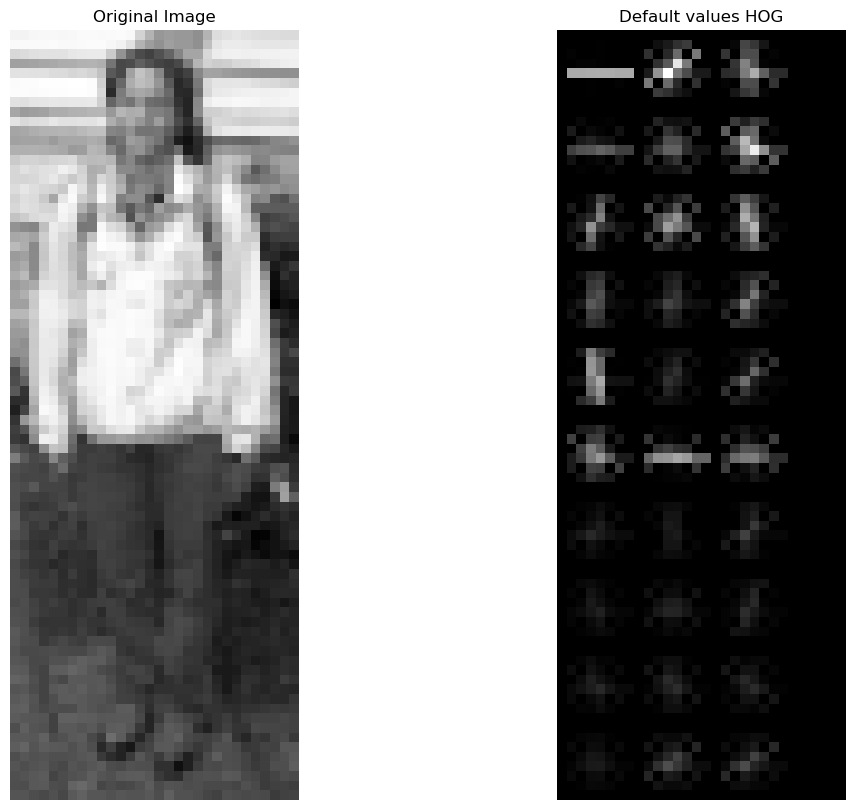

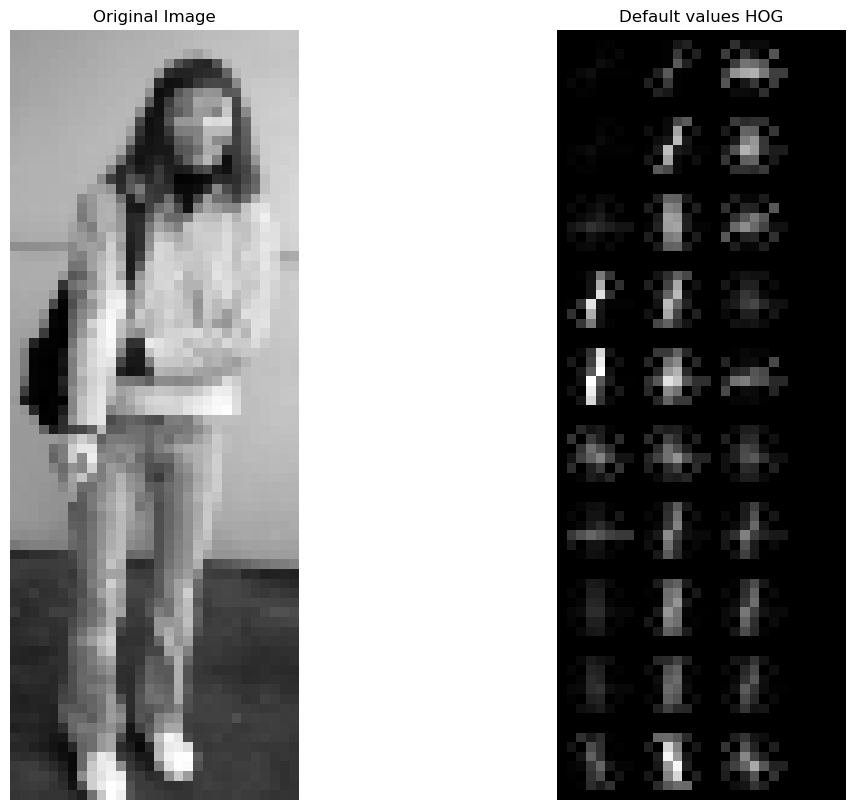

In [5]:
# Your solution

# Reading the template images
template_1 = imread('images/template1.png')
template_2 = imread('images/template2.bmp')
template_3 = imread('images/template3.png')
    
# Convert images to grayscale
template_1_gray = to_grayscale(template_1)
template_2_gray = to_grayscale(template_2)
template_3_gray = to_grayscale(template_3)

# Obtain HOG descriptors with default parameters
hog_template_1 = getHOG(template_1_gray)
hog_template_2 = getHOG(template_2_gray)
hog_template_3 = getHOG(template_3_gray)

# Visualize the images
images = [template_1_gray, hog_template_1]
titles = ['Original Image', 'Default values HOG']
showImage((20, 10), images, titles)

images = [template_2_gray, hog_template_2]
titles = ['Original Image', 'Default values HOG']
showImage((20, 10), images, titles)

images = [template_3_gray, hog_template_3]
titles = ['Original Image', 'Default values HOG']
showImage((20, 10), images, titles)

**Ex.1.2** (2 points) Apply the previous templates to the image: `images/TestPersonImages/person_027.bmp`. Read the image and slide a window on each template to store the most similar Region of Interest, using Norm 2 (np.linalg.norm). Visualize the images in a 1x3 grid of images, like in the example below. All the images have been resized to accelerate the computation.

*Hint*: This exercise could take up a few seconds running, however it should not take minutes.
<img src="images/exercise12.png" width="515" height="350">

In [6]:
from queue import PriorityQueue

def compare(templates, image, orientations, pixels_per_cell, cells_per_block, channel_axis=None):
    # Compute the HOG descriptor for the template images
    hog_template_1 = getHOG(templates[0])
    hog_template_2 = getHOG(templates[1])
    hog_template_3 = getHOG(templates[2])
    
    # Calculate the maximum x and y coordinates for the sliding window based on image and template sizes
    matchx = image.shape[0] - templates[0].shape[0]
    matchy = image.shape[1] - templates[0].shape[1]

    # Compute the HOG descriptor for the entire test image
    result = getHOG(image, orientations, pixels_per_cell,
                    cells_per_block, channel_axis)
    
    # PriorityQueue to store distances and coordinates, for finding the minimum distance
    pq_1 = PriorityQueue()
    pq_2 = PriorityQueue()
    pq_3 = PriorityQueue()
    
   # Sliding window: iterate over the test image with a step size of 5 pixels
    for i in range(0,matchx,5):
        for j in range(0,matchy,5):
            # Extract the region of the image corresponding to the current window position
            region_1 = image[i:i+templates[0].shape[0],j:j+templates[0].shape[1]]
            region_2 = image[i:i+templates[1].shape[0],j:j+templates[1].shape[1]]
            region_3 = image[i:i+templates[2].shape[0],j:j+templates[2].shape[1]]
            
            
            hog_region_1 = getHOG(region_1, orientations, pixels_per_cell,
                    cells_per_block, channel_axis)
            hog_region_2 = getHOG(region_2, orientations, pixels_per_cell,
                    cells_per_block, channel_axis)
            hog_region_3 = getHOG(region_3, orientations, pixels_per_cell,
                    cells_per_block, channel_axis)
            
            hog_region_rescaled_1 = exposure.rescale_intensity(hog_region_1, in_range=(0,20))
            hog_region_rescaled_2 = exposure.rescale_intensity(hog_region_2, in_range=(0,20))
            hog_region_rescaled_3 = exposure.rescale_intensity(hog_region_3, in_range=(0,20))
            
            # Calculate the Euclidean distance between the HOG descriptor of the region and the template
            hog_distance_1 = np.linalg.norm(hog_region_rescaled_1 - hog_template_1)
            hog_distance_2 = np.linalg.norm(hog_region_rescaled_2 - hog_template_2)
            hog_distance_3 = np.linalg.norm(hog_region_rescaled_3 - hog_template_3)

            # Store the distance and coordinates in the PriorityQueue
            info = [i, j]
            
            pq_1.put((hog_distance_1, info))
            pq_2.put((hog_distance_2, info))
            pq_3.put((hog_distance_3, info))
                   
    # Retrieve the coordinates of the region with the minimum distance to the template
    inf_1 = pq_1.get()[1]
    minX_1 = inf_1[0]
    minY_1 = inf_1[1]
    
    inf_2 = pq_2.get()[1]
    minX_2 = inf_2[0]
    minY_2 = inf_2[1]
    
    inf_3 = pq_3.get()[1]
    minX_3 = inf_3[0]
    minY_3 = inf_3[1]

    # Draw rectangles on the original image and the HOG image to indicate the detected region
    rect_1 = patches.Rectangle((minY_1,minX_1), templates[0].shape[1], templates[0].shape[0], edgecolor='r', facecolor='none')
    rect_2 = patches.Rectangle((minY_2,minX_2), templates[1].shape[1], templates[1].shape[0], edgecolor='r', facecolor='none')
    rect_3 = patches.Rectangle((minY_3,minX_3), templates[2].shape[1], templates[2].shape[0], edgecolor='r', facecolor='none')

    # Set up the figure for visualization
    _, position = plt.subplots(ncols=3, figsize=(15,20))
    position[0].imshow(image, cmap='gray')
    position[0].add_patch(rect_1)
    position[0].set_title("Silhouette")
    
    position[1].imshow(image, cmap='gray')
    position[1].add_patch(rect_2)
    position[1].set_title("Template 1")
    
    position[2].imshow(image, cmap='gray')
    position[2].add_patch(rect_3)
    position[2].set_title("Template 2")
    
    plt.show()

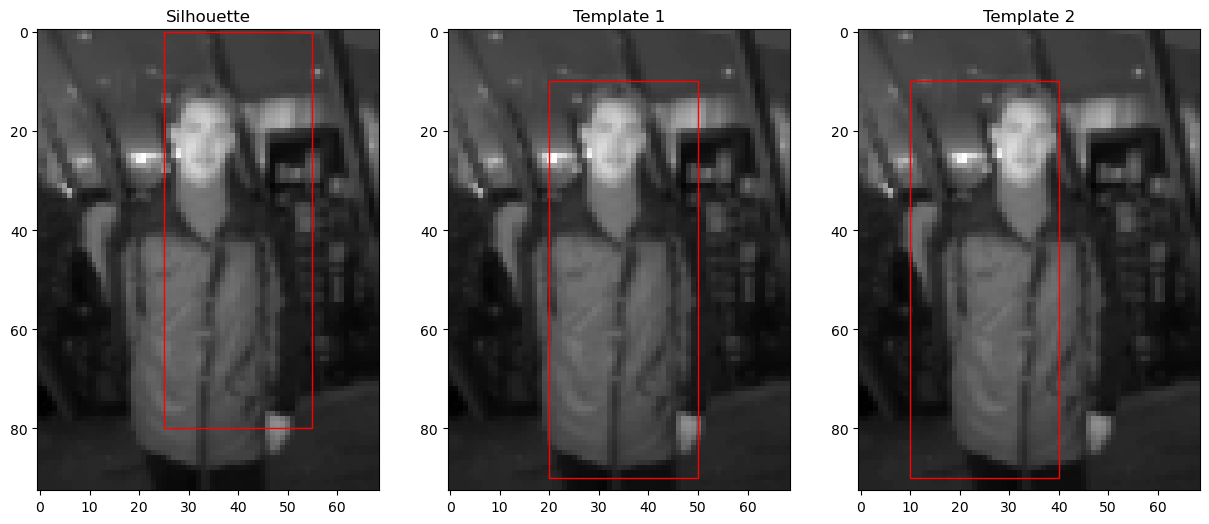

In [7]:
# Your solution

# Read the image
test_image = imread('images/TestPersonImages/person_025.bmp')

# Save the templates in a list, already in grayscale
templates = [template_1_gray, template_2_gray, template_3_gray]

# Apply comparison with the 3 templates
compare(templates, to_grayscale(test_image), orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(3, 3))

Which template has been the best choice for the detection task?

**In our particular case we can see that the template 1 (template1.png) has been the best choice for this particular detection task. It is true that this results also depend on my choice for the HOG descriptor parameters, different ones might perform slightly different from mine.**

The images are smaller in size than the ones used in class. Has this influenced the results?

**Comparing the results I have achieved with the ones we got from P4, I would certainly say that the size of the image has not influenced the results, because we can see that template 1 performs really well when trying to detect the person in the image.**

**HOG is not invariant to object orientation, but it is pretty robust to variations in geometric and photometric transformations.**

## Exercise 2

### Autonomous cars

A big car company has started a proyect to create autonomous cars. The autonomous car market is quite advanced, and they are working around the clock to catch up with their competitors and establish themselves as a leading brand in autonomous electric vehicles by 2026. The goal is to recognize different vehicles on the road to react to unforeseen events. Considering your performance in the previous task, you are now a member of this team.

**Ex 2.1** (2 points) Read the images from the directories `./images/vehicles/bike`, `./images/vehicles/boat`, `./images/vehicles/bus`, `./images/vehicles/car`, `./images/vehicles/cycle`. Transform the RGB images to grayscale and resize them to 100x100 pixels (to reduce computation time). Build two arrays: one, X, with all the features, and the other, y, containing the label of the images. The class_labels for the images should be: 0 = bike, 1 = boat, 2 = bus, 3 = car, 4 = cycle.

To check the correctness of the exercise, visualize the images number 0, 150 and 300, along with their type. The next image is an example of the result:

<img src="images/exercise21.png" width="515" height="350">

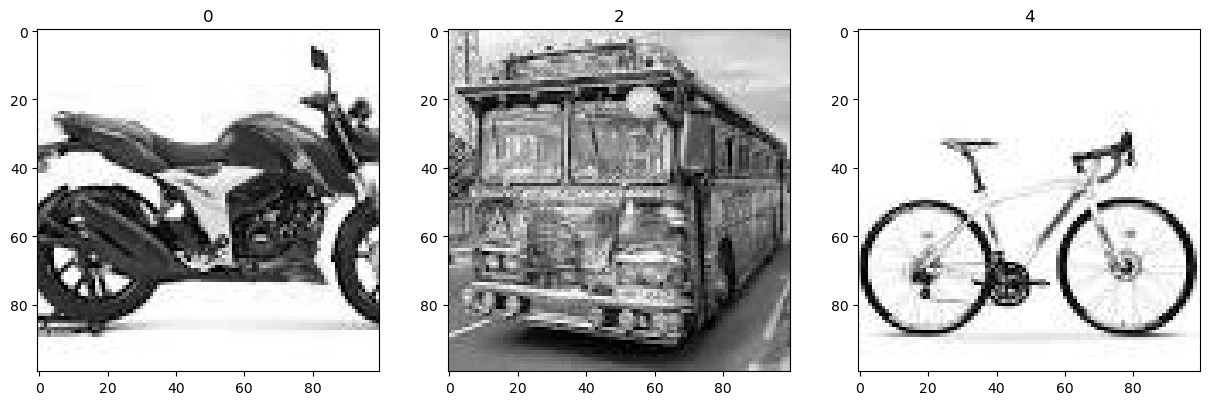

In [8]:
# Your solution

# Define paths and labels
subfolders = ['bike', 'boat', 'bus', 'car', 'cycle']
label_mapping = {name: idx for idx, name in enumerate(subfolders)}
image_size = (100, 100) # Resize size
base_path = 'images/vehicles/'

# Two arrays
X = [] # All the features
y = [] # Label of the images

 # Process all images in the subfolder
for vehicle in subfolders:
    path = base_path + vehicle + '/*.jpg'
    
    # Read all the images from the path
    all_images = io.ImageCollection(path)

    # Transform to grayscale
    vehicle_images = [to_grayscale(image) for image in all_images]
        
    # Reduce the images size to (100, 100)
    vehicle_images = [resize(image, image_size) for image in vehicle_images]
    
    for image in vehicle_images:
        # Append to all the images list
        X.append(image)
        
        # Append the label of the current image
        y.append(label_mapping[vehicle])
        

# Visualize images 0, 150, 294 along with their type
# There are no 300 images, just 295, so I use 294 for the last one
_, position = plt.subplots(ncols=3, figsize=(15,20))
position[0].imshow(X[0], cmap='gray')
position[0].set_title(y[0])
    
position[1].imshow(X[150], cmap='gray')
position[1].set_title(y[150])
    
position[2].imshow(X[294], cmap='gray')
position[2].set_title(y[294])

plt.show()

**Ex 2.2** (1,5 points) Divide the dataset into train set and test set, the test set size being the 30% of the total dataset. Create a PCA object of 30 components and visualize 20 principal components.
​
The next image is an example of the result:
​
<img src="images/exercise32.png" width="515" height="350">

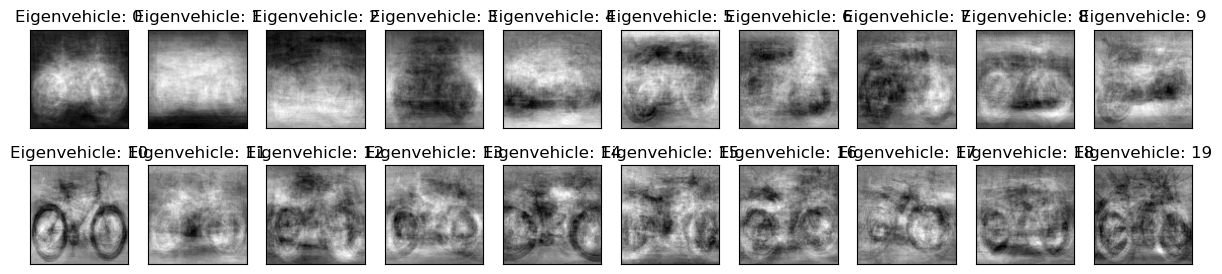

In [9]:
# Your solution

# Reshape the images array to 2D, as required by PCA
n_samples = len(X)
X1 = np.array(X)

data = X1.reshape(n_samples, -1)

# Divide the dataset intro train set and test set (test size being 30%
# of the total dataset)
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, train_size=0.7, random_state=42)

# PCA object with 30 components
pca = PCA(n_components=30)
pca.fit(X_train)

# Extract the principal components from the PCA model and select the first 20 
principal_components = pca.components_
principal_components = principal_components[:20]

# Reshape each principal component into the original image dimensions
principal_components = [component.reshape((100, 100)) for component in principal_components]

fig = plt.figure(figsize=(15, 5))

for i, component in enumerate(principal_components):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(component,cmap='gray')
    title = "Eigenvehicle: " + str(i)
    ax.set_title(title)

plt.show()

## Exercise 3

### Introducing the AdaBoost

The perfomance in the previous exercise has been better than expected. The board of inverstors is happy with your achievements and have moved the release date of the new software from 2026 to 2025. That means there is more work to do: you now need to create an algorithm able to classify a larger volume of images. Currently, you will continue using the same set of images as in the previous exercise.

**Ex 3.1** (2 points) Use the images from the previous directories `./images/vehicles/bike`, `./images/vehicles/boat`, `./images/vehicles/bus`, `./images/vehicles/car`, `./images/vehicles/cycle`. Resize them to 15x15 pixels (to reduce computation time even more). Build an array X, using the built `extract_feature_image` method seen in P5, with all the given Haar-like features (which are usually used for faces).
                 
Print the shape of both arrays. The shape of X should be (305, 78460), and the shape of y (305,).

```python
feature_types = ['type-2-x', 'type-2-y',
                 'type-3-x', 'type-3-y',
                 'type-4']
```

*Hint*: This exercise could take up a few seconds running, however it should not take minutes.

In [10]:
feature_types = ['type-2-x', 'type-2-y',
                 'type-3-x', 'type-3-y',
                 'type-4']

In [11]:
from skimage.feature import haar_like_feature

def extract_feature_image(image, feature_type, feature_coord=None):
    # Convert the input image to its integral image representation
    iimage = integral_image(image)
    width, height = iimage.shape
    # Calculate and return the specified feature type from the integral image
    return haar_like_feature(iimage, 0,0, width, height, feature_type, feature_coord)

In [12]:
# Your solution

image_size = (15, 15)

vehicle_images = [resize(image, image_size) for image in X]

X_1 = [] # Haar-like features
y_1 = y # Labels vector (we have it from the previous exercise)

# Extract features for all the vehicles in the images
for vehicle in vehicle_images: 
    X_1.append(extract_feature_image(vehicle, feature_types))
    
print("X shape: ", np.array(X_1).shape)
print("y shape: ", np.array(y_1).shape)

X shape:  (295, 24976)
y shape:  (295,)


**Ex 3.2** (1,5 points) Train an Adaboost classifier with 10 estimators. Use the *predict* and *score* methods of the classifier to evaluate the testing accuracy *(percentage of correctly classified images)*. The test size must be the 30% (i.e. 0.3) of the whole dataset. Use the ``train_test_split()`` function from `sklearn.model_selection`. The labels used in this function should be the same as in the previous exercise.

In [13]:
# Your solution

from sklearn.ensemble import AdaBoostClassifier

# Test parameters (test_size = 30%)
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.3,random_state=0, stratify=y_1)

# Adaboost classifier with 10 estimators
ada_model = AdaBoostClassifier(n_estimators=10, random_state=0)
ada_model.fit(X_train, y_train)

prediction = ada_model.predict(X_test)
score = ada_model.score(X_test, y_test)

# Prediction
print("Prediction:")
print(prediction)
print("\n")

# Score
print("Score:")
print(score)

Prediction:
[3 0 0 0 4 1 4 1 3 1 1 4 1 4 4 1 4 3 0 1 1 1 4 1 3 1 4 1 3 0 1 3 3 1 4 1 3
 3 0 3 3 0 0 1 0 1 3 4 3 3 1 1 1 0 3 1 1 3 1 3 3 3 3 1 1 1 1 3 1 3 3 3 1 4
 1 1 3 1 0 1 4 0 3 0 4 4 4 3 1]


Score:
0.38202247191011235
